In [1]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np
import matplotlib.pyplot as plt
import robot_sim as sim

In [2]:
# generate reference trajectory
dt = 0.01
xa1 = np.zeros((mf.STATE_LEN, 1)); xa1[:6] = np.array([[-1.57],[0],[0.5],[5],[0.1],[-0.1]])
xb1 = np.zeros((mf.STATE_LEN, 1)); xb1[:6] = np.array([[0],[0],[6],[6.5],[0.2],[0]])
xc1 = np.zeros((mf.STATE_LEN, 1)); xc1[:6] = np.array([[-1.57],[0],[9.5],[4],[0],[-0.1]])

posa, y_IMUa = traj.gen_poly_traj(xa1, xb1, t0=0, tf=30, dt=dt)
posb, y_IMUb = traj.gen_poly_traj(xb1, xc1, t0=0, tf=30, dt=dt)
pos1 = np.append(posa, posb, axis=1)
y_IMU1 = np.append(y_IMUa, y_IMUb, axis=1)

xa2 = np.zeros((mf.STATE_LEN, 1)); xa2[:6] = np.array([[0],[0],[0.5],[3],[0.1],[0]])
xb2 = np.zeros((mf.STATE_LEN, 1)); xb2[:6] = np.array([[3.14],[0],[7],[5],[-0.5],[0]])
xc2 = np.zeros((mf.STATE_LEN, 1)); xc2[:6] = np.array([[-1.57],[0],[3],[0.5],[0],[-0.1]])

posa, y_IMUa = traj.gen_poly_traj(xa2, xb2, t0=0, tf=30, dt=dt)
posb, y_IMUb = traj.gen_poly_traj(xb2, xc2, t0=0, tf=30, dt=dt)
pos2 = np.append(posa, posb, axis=1)
y_IMU2 = np.append(y_IMUa, y_IMUb, axis=1)

xa3 = np.zeros((mf.STATE_LEN, 1)); xa3[:6] = np.array([[1.57],[0],[0.5],[0.5],[0],[0.1]])
xb3 = np.zeros((mf.STATE_LEN, 1)); xb3[:6] = np.array([[0],[0],[6],[2],[0],[-0.1]])
xc3 = np.zeros((mf.STATE_LEN, 1)); xc3[:6] = np.array([[-1.57],[0],[9],[3],[0],[0.1]])

posa, y_IMUa = traj.gen_poly_traj(xa3, xb3, t0=0, tf=30, dt=dt)
posb, y_IMUb = traj.gen_poly_traj(xb3, xc3, t0=0, tf=30, dt=dt)
pos3 = np.append(posa, posb, axis=1)
y_IMU3 = np.append(y_IMUa, y_IMUb, axis=1)

pos_len = pos1.shape[1] # Assumes that all paths have the same length

# Generate anchors position:
xanc1 = np.zeros((mf.STATE_LEN, 1)); xanc1[mf.X_P] = np.array([[5],[4]])

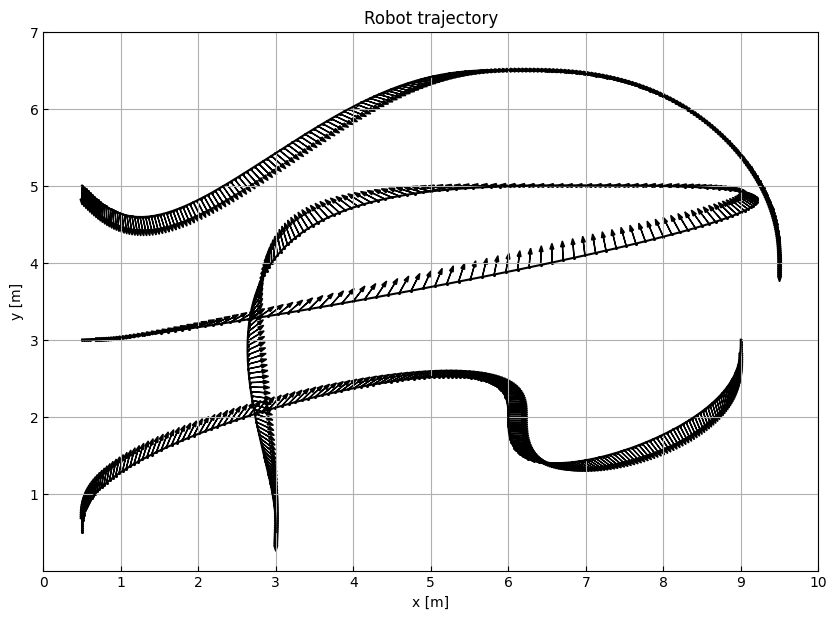

In [3]:
# Generate noise
R_b = 0.0009
R_r = 0.001
R_w = 0.0002
R_a = 0.004

Q=np.diag([0.1e6, 8.0e6, 8.0e6, 0.000001, 0.00001, 0.00001])
R=np.diag([R_b, R_r, R_w, R_a, R_a]) # approx vaules from datasheets
P=np.diag([0,0,0,0,0,0,0,0,0.004,0.6,0.6]) # Initialize with system noise for bias

np.random.seed(1000)
y_IMU1 = traj.gen_noise(y_IMU1, dt=1, sigma=np.diag([0, 0, 0]), bias=np.array([[0.0],[0.],[-0.]]))
y_IMU2 = traj.gen_noise(y_IMU2, dt=1, sigma=np.diag([0, 0, 0]), bias=np.array([[-0.0],[0.],[0.]]))
y_IMU3 = traj.gen_noise(y_IMU3, dt=1, sigma=np.diag([0, 0, 0]), bias=np.array([[0.0],[-0.],[0.]]))

# Preview plot:
fig, axtest = rp.setup_plot()
rp.plot_position(axtest, pos1[:,::25], color='black')
rp.plot_position(axtest, pos2[:,::25], color='black')
rp.plot_position(axtest, pos3[:,::25], color='black')


In [4]:
# Run the algorithm
# Setup robots and anchors:
robot1 = sim.Robot_single(x0=xa1, path=pos1, imu=y_IMU1, dt=dt, Q=Q, R=R, P=P)
robot2 = sim.Robot_single(x0=xa2, path=pos2, imu=y_IMU2, dt=dt, Q=Q, R=R, P=P)
robot3 = sim.Robot_single(x0=xa3, path=pos3, imu=y_IMU3, dt=dt, Q=Q, R=R, P=P)
anchor1 = sim.Anchor(x0=xanc1)

np.random.seed(0)
for i in range(pos_len-1):
    robot1.predict()
    robot2.predict()
    robot3.predict()
    if (i % 100 == 0):
        robot1.anchor_meas(anchor1, sr=0, sb=0)
        robot2.robot_meas(robot1, sr=0, sb=0)
        robot3.robot_meas(robot2, sr=0, sb=0)
        #robot1.robot_meas(robot3, sr=R_r, sb=R_b)

In [8]:
# Run LUFT algorithm
robotL1 = sim.robot_luft(x0=xa1, path=pos1, imu=y_IMU1, dt=dt, Q=Q, R=R, P=P, id=111)
robotL2 = sim.robot_luft(x0=xa2, path=pos2, imu=y_IMU2, dt=dt, Q=Q, R=R, P=P, id=222)
robotL3 = sim.robot_luft(x0=xa3, path=pos3, imu=y_IMU3, dt=dt, Q=Q, R=R, P=P, id=333)

np.random.seed(0)
for i in range(pos_len-1):
    robotL1.predict()
    robotL2.predict()
    robotL3.predict()
    if (i > 0 and i % 100 == 0):
        print(i)
        robotL1.anchor_meas(anchor1, sr=0, sb=0)
        #robotL2.robot_meas_luft(robotL1, sr=0, sb=0)
        #robotL3.robot_meas_luft(robotL2, sr=0, sb=0)
        #robot1.robot_meas(robot3, sr=R_r, sb=R_b)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000


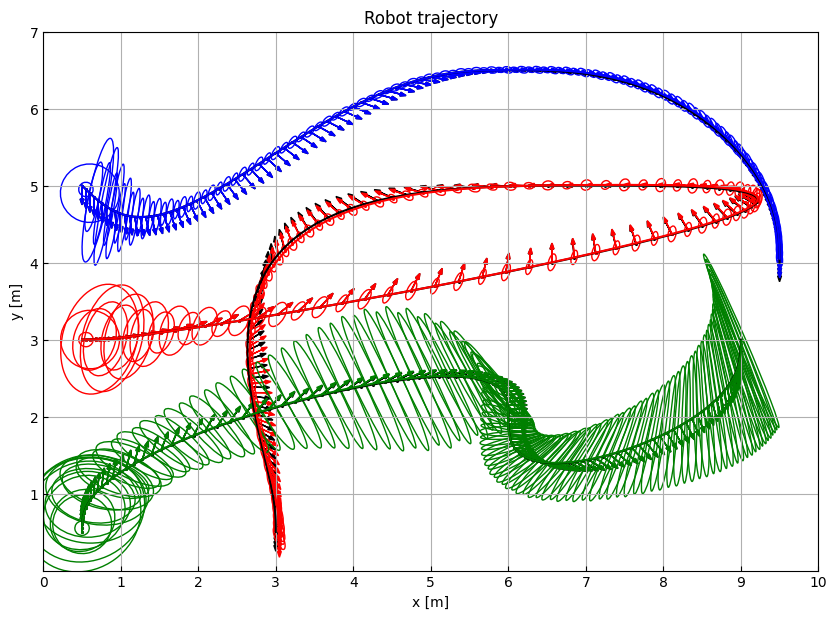

In [ ]:
# Plot the quantuties we have logged:
x_log1 = robot1.x_log
P_log1 = robot1.P_log
x_log2 = robot2.x_log
P_log2 = robot2.P_log       
x_log3 = robot3.x_log
P_log3 = robot3.P_log 

# Plot ground truth
fig, ax = rp.setup_plot()
rp.plot_position(ax, pos1[:,::50], color='black')
rp.plot_position(ax, pos2[:,::50], color='black')
rp.plot_position(ax, pos3[:,::50], color='black')

# Plot states of robots:
rp.plot_position2(ax, x_log1[:,::50], P_log1[:,:,::50], color='blue')
rp.plot_position2(ax, x_log2[:,::50], P_log2[:,:,::50], color='red')
rp.plot_position2(ax, x_log3[:,::50], P_log3[:,:,::50], color='green')

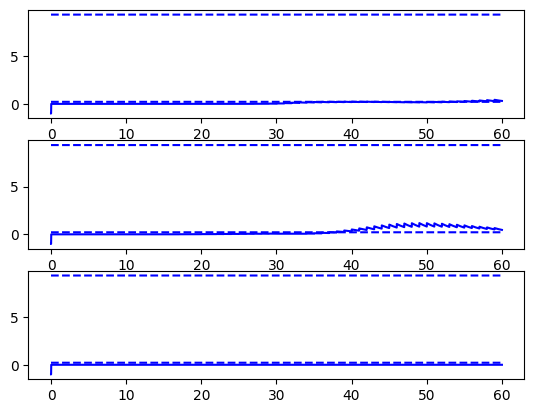

In [ ]:
# NEES analysis
# If higher than confidence interval, then the estimate is overconfident
fig, axs = plt.subplots(3)
pos_ind = [0, 2, 3]
rp.plot_NEES(axs[0], 
             x_est=x_log1[pos_ind,:],
             x_true=robot1.path[:3,:], 
             P=P_log1[np.ix_(pos_ind, pos_ind)], 
             dt=dt,
             prob=0.95)
rp.plot_NEES(axs[1], 
             x_est=x_log2[pos_ind,:],
             x_true=robot2.path[:3,:], 
             P=P_log2[np.ix_(pos_ind, pos_ind)], 
             dt=dt,
             prob=0.95)
rp.plot_NEES(axs[2], 
             x_est=x_log3[pos_ind,:],
             x_true=robot3.path[:3,:], 
             P=P_log3[np.ix_(pos_ind, pos_ind)], 
             dt=dt,
             prob=0.95)

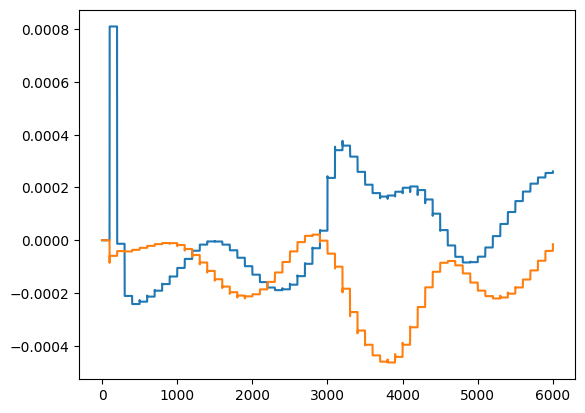

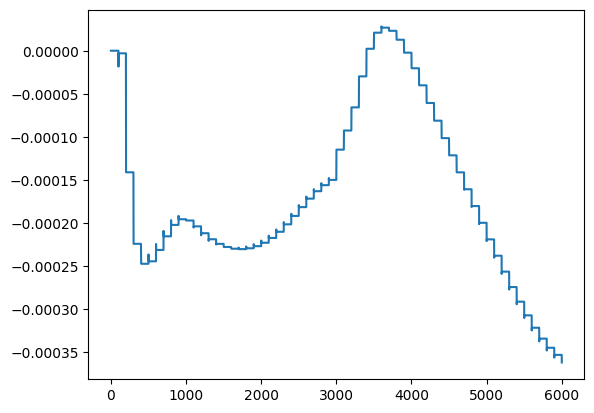

In [ ]:
# Plot bias states:
# For acc:
plt.figure()
plt.plot(x_log2[9,:])
plt.plot(x_log2[10,:])
plt.figure()
plt.plot(x_log2[8,:])